In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import requests
import numpy as np
import time
import yfinance as yf
import functions as f


%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Natural Language Processing and ML models

In [2]:
import nltk
from sklearn.preprocessing import LabelEncoder #Convert text into numerical form
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize #import the sentence and word tokenizer

#Punkt Sentence Tokenizer. This tokenizer divides a text into a list of sentences, by using an unsupervised algorithm 
#to build a model for abbreviation words, collocations, and words that start sentences.
##Download the punkit
nltk.download('punkt') 

#NLTK stopwords library
nltk.download('stopwords')
from nltk.corpus import stopwords


#We will use porter stemming method
# There is also other types of stemming such as lancaster stemming
from nltk.stem.porter import PorterStemmer 
port = PorterStemmer()

#Word lemmatisation
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')#Download wordnet
wnet = WordNetLemmatizer()


[nltk_data] Downloading package punkt to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Kwan Yui
[nltk_data]     Yang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Convert from date to unix and unix to date

In [3]:
def convert_to_unix(date):
  unixd = dt.datetime.strptime(date,"%Y-%m-%d")
  return time.mktime(unixd.timetuple())

  
def convert_to_date(timestamp):
  return str(dt.datetime.fromtimestamp(int(timestamp)).date())

In [4]:
print(f.convert_to_unix('2020-02-20'))

1582128000.0


# Use pushshift api to retrieve reddit data

In [5]:

def get_data(query,
            subreddit,
            before,
            after,
            fields,
            size,
            sort_type):
    url = f"https://api.pushshift.io/reddit/search/submission/?q={query}&before={before}&after={after}&fields={fields}&size={size}&sort_type={sort_type}"
    request = requests.get(url)
    json_response = request.json()
    return json_response['data']

def multiple_data_call(lookback_period:int,
                **kwargs):
        df = pd.DataFrame(columns = ['date','reddit_title'])
        for i in range(1,lookback_period+1):
                try:
                        after = str(i+1)+'d'
                        before = str(i)+'d'
                        response=get_data(query,subreddit,before,after,fields,size,sort_type)
                        titles = []
                        date = []         
                        for line in response:
                                date.append(convert_to_date(line['created_utc']))
                                titles.append(line['title'])
                        temp = pd.DataFrame(np.column_stack([date,titles]),columns = ['date','reddit_title'])
                        df = pd.concat([df,temp])
                except:
                        print(f"Error encountered for {convert_to_date(line['created_utc'])}")
                        continue
        df.index = list(range(len(df)))
        return df
                


[*********************100%***********************]  7 of 7 completed


<AxesSubplot:title={'center':'Cryptocurrency prices'}, xlabel='Date'>

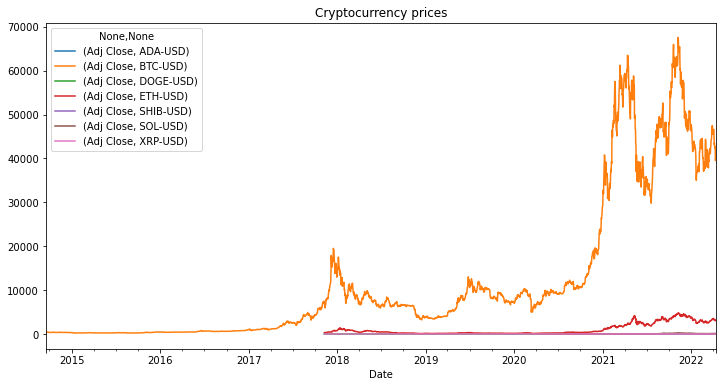

In [6]:
tickerlist = ['BTC-USD','ETH-USD','SOL-USD','XRP-USD','ADA-USD','DOGE-USD','SHIB-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = tickerlist
df = df.iloc[:,:7]['2007':]
df.plot(figsize = (12,6),title = 'Cryptocurrency prices')

# Calculate rolling 7-day return 

In [7]:
pct_change = pd.DataFrame(df.pct_change(periods = 7).fillna(method = 'bfill'))
pct_change.columns = columns

In [8]:
pct_change = pd.DataFrame(df.pct_change(periods = 7).fillna(method = 'bfill'))
pct_change.columns = columns
pct_change['date'] = pct_change.index.astype(str)
pct_change['index'] = range(len(pct_change))
pct_change.set_index('index',drop = True,inplace = True)
pct_change = pct_change.shift(-7).dropna()
pct_change

,BTC-USD,ETH-USD,SOL-USD,XRP-USD,ADA-USD,DOGE-USD,SHIB-USD,date
index,,,,,,,,
0,-0.139550,-0.074626,-0.017668,0.031289,inf,-0.305268,0.044228,2014-09-24
1,-0.139550,-0.030313,-0.017668,0.031289,inf,-0.305268,0.044228,2014-09-25
2,-0.139550,0.024390,-0.017668,0.031289,inf,-0.305268,0.044228,2014-09-26
3,-0.139550,-0.022949,-0.017668,0.031289,inf,-0.305268,0.044228,2014-09-27
4,-0.139550,-0.054260,-0.017668,0.031289,inf,-0.305268,0.044228,2014-09-28
...,...,...,...,...,...,...,...,...
2753,-0.119355,-0.086297,0.008732,-0.074641,-0.076923,-0.183217,-0.089018,2022-04-08
2754,-0.096013,-0.067296,0.038801,-0.053161,-0.038462,-0.145433,-0.074352,2022-04-09
2755,-0.130745,-0.091401,0.021044,-0.088272,-0.074074,-0.183022,-0.102421,2022-04-10


In [9]:
crypto_dict = {
    'BTC-USD':'bitcoin',
    'ETH-USD': 'ethereum',
    'DOGE-USD':'dogecoin',
    'ADA-USD':'cardano',
    'SOL-USD':'solana',
    'SHIB-USD':'SHIBArmy',
    'XRP-USD':'ripple'
}


In [110]:

model_dict = {}

for coin in tickerlist:
    query = coin
    subreddit=crypto_dict[coin] #Define Your subreddit
    size = 100
    after="2d"
    before = "1d"
    fields = "title,created_utc"
    sort_type = "created_utc" #score, num_comments, default=created_utc

    data = multiple_data_call(lookback_period=1000,
                query = query,
                subreddit=subreddit,
                fields=fields,
                sort_type=sort_type,
                size = size)
    model_dict[subreddit] = data
    print(f'Scrapping complete for {coin}... ')
    data.to_csv(f"{subreddit}_dataset.csv")


Error encountered for 2022-03-19
Error encountered for 2022-03-17
Error encountered for 2022-03-06
Error encountered for 2022-03-04
Error encountered for 2022-03-04
Error encountered for 2022-02-25
Error encountered for 2022-02-14
Error encountered for 2022-02-02
Error encountered for 2022-01-31
Error encountered for 2022-01-25
Error encountered for 2022-01-25
Error encountered for 2022-01-22
Error encountered for 2022-01-22
Error encountered for 2022-01-15
Error encountered for 2022-01-10
Error encountered for 2022-01-10
Error encountered for 2022-01-07
Error encountered for 2022-01-04
Error encountered for 2021-12-28
Error encountered for 2021-12-26
Error encountered for 2021-12-22
Error encountered for 2021-12-19
Error encountered for 2021-12-19
Error encountered for 2021-12-12
Error encountered for 2021-12-09
Error encountered for 2021-12-09
Error encountered for 2021-11-25
Error encountered for 2021-11-25
Error encountered for 2021-11-20
Error encountered for 2021-11-14
Error enco

In [12]:
for coin in model_dict:
    model_dict[coin].to_csv(f"{coin}_dataset.csv")

In [28]:
datasets = {}
for key in crypto_dict:
    df = pd.read_csv(crypto_dict[key]+'_dataset.csv', index_col = 0)
    df.columns = ['date','reddit_title']
    df = pd.DataFrame(df.groupby(['date'])['reddit_title'].apply(lambda x:','.join(x)))
    merged_df = df.merge(pct_change[['date',key]], on='date',how = 'left')
    merged_df['class'] = [0 if x<0 else 1 for x in merged_df[key]]
    merged_df = merged_df.dropna()
    merged_df = merged_df[merged_df[key]!=float('inf')]
    datasets[key] = merged_df

# Natural Language Processing with NLTK

In [11]:


# Data Preparation
def prepare_data(data: pd.Series)-> list:
    # 1. Convert to lower case
    print('Converting to lower case......')
    casefolded_data = data.str.strip().str.lower()

    #2 Tokenize data
    print('Tokenizing data......')
    sent_tokenized_data = list(map(sent_tokenize,casefolded_data))

    #3 Remove stopwords from data
    print('Removing stopwords......')
    def remove_stopwords(sentence_list:list):
        wordlist = [word for word in sentence_list if word not in stopwords.words('english')]
        return wordlist
    stopwords_cleaned = list(map(remove_stopwords,sent_tokenized_data))

    #4 Stem words
    print('Stemming words......')
    port = PorterStemmer()
    def stem_words(wordlist:list):
        stemmed_w_list = [port.stem(word) for word in wordlist]
        return stemmed_w_list
    stemmed_data = list(map(stem_words,stopwords_cleaned))

    #5 wnet = WordNetLemmatizer()
    print('Lemmatizing words......')
    def lem_words(wordlist:list):
        lemmed_w_list = [wnet.lemmatize(word) for word in wordlist]
        return lemmed_w_list
    processed_data = list(map(lem_words,stemmed_data))
    

    return processed_data
    
    
    


In [12]:
#Convert to lower case
def to_lower(df_column: pd.Series)->pd.Series:
    casefolded_data = df_column.str.strip().str.lower()
    return casefolded_data


def remove_stopwords(sentence_list:list):
    wordlist = [word for word in sentence_list if word not in stopwords.words('english')]
    return wordlist
# data['reddit_title'] = list(map(remove_stopwords,data['reddit_title']))

def stem_words(wordlist:list):
    stemmed_w_list = [port.stem(word) for word in wordlist]
    return stemmed_w_list

# data['reddit_title'] = list(map(stem_words,data['reddit_title']))

def lem_words(wordlist:list):
    lemmed_w_list = [wnet.lemmatize(word) for word in wordlist]
    return lemmed_w_list

# data['reddit_title'] = list(map(lem_words,data['reddit_title']))

def to_string(wlist:list):
    strng = ' '.join([str(item) for item in wlist])
    return strng
#for i in merged_data.index:
#   data.loc[i,'reddit_title'] = to_string(data.loc[i,'reddit_title'])



### Clean the data using the prepare_data function
1. Create empty dictionaries to store the cleaned datasets 

In [14]:
cleaned_datasets = {}
backtest_set = {}

for key in datasets:
    if key == 'BTC-USD':
        df = datasets[key]
        df['reddit_title'] = f.prepare_data(df['reddit_title'])
        for i in df.index:
            df.loc[i,'reddit_title'] = to_string(df.loc[i,'reddit_title'])
        
        cleaned_datasets[key] = df

Converting to lower case......
Tokenizing data......
Removing stopwords......
Stemming words......
Lemmatizing words......


#### Take a look at a sample of the data

In [30]:
df = cleaned_datasets['BTC-USD']
df

,date,reddit_title,BTC-USD,class
0,2019-07-13,btc peer-to-peer trading rises amid ban on usd...,-0.136613,0
1,2019-07-14,"minedblock,[store] m9 crimson web fn, bayonet ...",-0.256803,0
2,2019-07-15,"bitcoin hiking towards 4050 dollar,bitcoin opp...",-0.260189,0
3,2019-07-16,"how the bitcoin price was changing,[h] *specia...",-0.332607,0
4,2019-07-17,get $50 usd unlocked instantly after making yo...,-0.232152,0
...,...,...,...,...
877,2022-04-04,"most trending cryptos today so far,coinbase re...",0.036542,1
878,2022-04-05,"most trending cryptos today so far,most trendi...",-0.017052,0
879,2022-04-06,"most trending cryptos today so far,stiri crypt...",-0.115605,0
880,2022-04-07,"most trending cryptos today so far,receive 10 ...",-0.043751,0


# Model Testing

In [70]:
df.index = df.date
X = df['reddit_title']
Y = df['class']
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=32)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()



In [46]:
## Log Reg
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter = 2000)
model = logisticRegr.fit(x_train,y_train)
model.score(x_test,y_test)

0.6949152542372882

In [56]:
##SVM
from sklearn import svm
model = svm.SVC()
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.6779661016949152

In [71]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

0.615819209039548

In [16]:
import datetime as dt
def rolling_backtest(scrapped_data, start_dt, end_dt):
    '''
    This is the rolling backtest function. For this, we train the model iteratively.
    1. We have a start date from which we want to train the model
    2. days = 90, means that we use 90 days as a starting point. I.e for the first day, we have already trained the model for 90 days
    3. As more days pass, we fit in more data into the model to fine tune predictions
    4. Store the predictions in a dictionary
    5. The training model used is a SUPPORT VECTOR MACHINE
    '''
    scrapped_data.index = scrapped_data['date']
    df = scrapped_data.loc[start_dt:end_dt]
    days = 90
    predictions = {}
    for date in df.index:
        try:
            start = dt.datetime.strptime(start_dt,'%Y-%m-%d')
            end = (start+dt.timedelta(days = days)).strftime('%Y-%m-%d')
            predict_date = (start+dt.timedelta(days = days)).strftime('%Y-%m-%d')
            start = start.strftime('%Y-%m-%d')
            days+=1

            subset = df.loc[start:predict_date]
            x_train = subset.loc[start:end]['reddit_title']
            x_test = subset.loc[predict_date][['reddit_title']]
            y_train = subset.loc[start:end]['class']
            y_test = subset.loc[predict_date][['class']]

            vec = CountVectorizer(stop_words='english')
            x_train = vec.fit_transform(x_train).toarray()
            x_test = vec.transform(x_test).toarray()

            ## Fit support vector machine
            model = svm.SVC()
            model.fit(x_train,y_train)
            predictions[predict_date] = model.predict(x_test)[0]
        except:
            continue

    return predictions

        
        



## Store backtest results in a dictionary

In [ ]:
backtest_results = {}
for crypto in crypto_dict:
    df = cleaned_datasets[crypto]
    predictions = rolling_backtest(scrapped_data = df,
                    start_dt = '2019-08-01',
                    end_dt = '2022-04-01')
    backtest_result = pd.DataFrame(predictions.values(), index = predictions.keys())
    backtest_result.columns = [crypto]
    backtest_results[crypto] = backtest_result

In [96]:
predictions = rolling_backtest(scrapped_data = cleaned_datasets['XRP-USD'],
                start_dt = '2019-08-01',
                end_dt = '2022-04-01')
backtest_result = pd.DataFrame(predictions.values(), index = predictions.keys())
backtest_result.columns = ['XRP-USD']
backtest_results['XRP-USD'] = backtest_result

In [97]:
data = backtest_results['BTC-USD']
for crypto in backtest_results:
    if crypto != 'BTC-USD':
        data = data.join(backtest_results[crypto])

# Save the data in a csv dataset => Look at Trading Strategy Jupyter Notebook for testing the results of our model's predictions

In [101]:
data = data.fillna(0)
data.to_csv('backtest_results.csv')

## Some crytocurrencies have NA values due to lack of data. For this we will thus be focusing on Bitcoin for testing out our strategy

In [27]:
data = pd.read_csv('backtest_results.csv')
data

,Unnamed: 0,BTC-USD,ETH-USD,DOGE-USD,ADA-USD,SOL-USD,SHIB-USD,XRP-USD
0,2020-12-13,0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-12-14,1,1.0,0.0,0.0,0.0,0.0,1.0
2,2020-12-15,1,1.0,0.0,0.0,0.0,0.0,1.0
3,2020-12-16,1,1.0,0.0,0.0,0.0,0.0,1.0
4,2020-12-17,1,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
405,2022-03-28,1,1.0,0.0,0.0,0.0,0.0,1.0
406,2022-03-29,1,1.0,1.0,0.0,0.0,0.0,1.0
407,2022-03-30,0,1.0,0.0,0.0,1.0,0.0,1.0
408,2022-03-31,1,1.0,0.0,0.0,0.0,0.0,1.0


## Testing Naive Bayes Algorithm

In [120]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(x_train, y_train)

MultinomialNB()

In [172]:
df.loc['2020-01-01':'2020-01-02']['reddit_title']

date
2020-01-01    calvin ayre: 2020 is bitcoins year of enterpri...
2020-01-02    bitcoin price analysis: btc/usd another triang...
Name: reddit_title, dtype: object

In [177]:
x_test

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 8, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       ...,
       [0, 5, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:

model.predict(x_test)

# Support Vector Machine Model

In [ ]:
from sklearn import svm
model = svm.SVC()
model.fit(x_train,y_train)

In [ ]:
trained_models = {}
trained_models['btc'] = model

In [123]:
model.score(x_test, y_test)

0.6779661016949152

In [140]:
y_pred = model.predict(x_test)

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1], dtype=int64)

# Workings (Ignore Below)

In [ ]:
df.index = df.date
X = df['reddit_title']
Y = df['class']
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()
xx_test = df['reddit_title'][['2020-01-01']]
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
xx_test = vec.transform(xx_test).toarray()

In [ ]:
query = "solana"
subreddit="solana" #Define Your Query
fields = "title,created_utc"
size = 100
sort_type = "score" #score, num_comments, default=created_utc
data = multiple_data_call(lookback_period=1000,
            query = query,
            subreddit=subreddit,
            fields=fields,
            sort_type=sort_type,
            size = size)



Error encountered for 2021-08-28
Error encountered for 2021-01-06
Error encountered for 2020-04-12


[*********************100%***********************]  1 of 1 completed
SOLUSD price


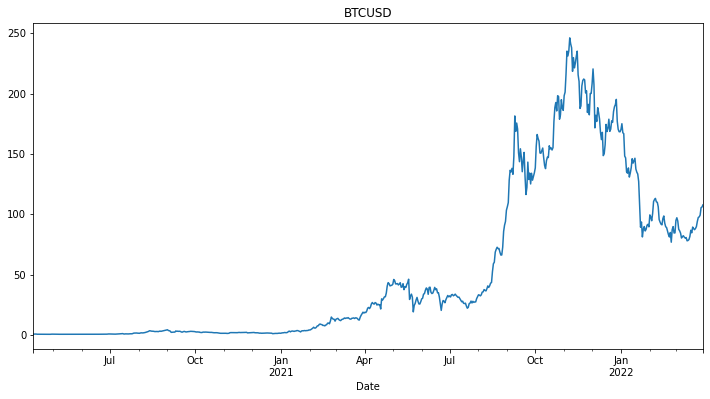

In [ ]:
tickerlist = ['SOL-USD']
df = yf.download(tickerlist, period = '1d', start = '2007-01-01',end = pd.Timestamp.today())
columns = df.columns
df = df.iloc[:,2]['2007':]
df.plot(figsize = (12,6),title = 'BTCUSD')
print('SOLUSD price')

In [ ]:
cleanedata1 = pd.DataFrame(data.groupby(['date'])['reddit_title'].apply(lambda x:','.join(x)))
merged_data = cleanedata1.merge(pct_change, on='date',how = 'left')
merged_data['class'] = [0 if x<0 else 1 for x in merged_data.pcnt_change]
merged_data = merged_data.dropna()
merged_data.to_csv('solana_dataset_merged.csv')
merged_data['reddit_title'] = prepare_data(merged_data['reddit_title'])
for i in merged_data.index:
    merged_data.loc[i,'reddit_title'] = to_string(merged_data.loc[i,'reddit_title'])
merged_data

Converting to lower case......
Tokenizing data......
Removing stopwords......
Stemming words......
Lemmatizing words......


,date,reddit_title,pcnt_change,class
0,2019-07-27,"the seven innovations of solana,welcome to /r/...",0.116026,1
1,2019-07-30,"solana poses itself as a ""decentralized libra""...",0.196390,1
2,2019-07-31,multicoin leads $20 million round for speed-fo...,0.191247,1
3,2019-08-02,when will the solana mainnet launch?,0.129084,1
4,2019-08-06,figment's first look at solana and stak,-0.040777,0
...,...,...,...,...
610,2022-03-18,fantastic twitter spaces with solana project f...,0.084459,1
611,2022-03-19,"based on solana, p2e esports company monkeylea...",0.061621,1
612,2022-03-20,"security factors,if solana doubled tomorrow......",0.083711,1
613,2022-03-21,"i definitely miss solana at $200.,""why doesn't...",0.148081,1


## Training the Solana NLP Model

In [ ]:
X = merged_data['reddit_title']
Y = merged_data['class']
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
# Vectorize text reviews to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()

sol_model = MultinomialNB()
sol_model.fit(x_train, y_train)
sol_model.score(x_test, y_test)

0.6341463414634146

In [ ]:
len(x_train[1])

7897

# Natural Language Processing with Pyspark (Failed)

In [77]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
 
dataset = [["I liked the movie", "positive"],
           ["It’s a good movie. Nice story", "positive"],
           ["Hero’s acting is bad but heroine looks good.\
            Overall nice movie", "positive"],
            ["Nice songs. But sadly boring ending.", "negative"],
            ["sad movie, boring movie", "negative"]]
             
dataset = pd.DataFrame(dataset)
dataset.columns = ["Text", "Reviews"]
 
dataset

,Text,Reviews
0,I liked the movie,positive
1,It’s a good movie. Nice story,positive
2,Hero’s acting is bad but heroine looks good. ...,positive
3,Nice songs. But sadly boring ending.,negative
4,"sad movie, boring movie",negative


In [75]:

nltk.download('stopwords')
 
corpus = []
 
for i in range(0, 5):
    text = re.sub('[^a-zA-Z]', '', dataset['Text'][i])
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = ''.join(text)
    corpus.append(text)
 
# creating bag of words model
cv = CountVectorizer(max_features = 1500)
 
X = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:, 1].values
# splitting the data set into training set and test set

 
X_train, X_test, y_train, y_test = train_test_split(
           X, y, test_size = 0.25, random_state = 0)

In [76]:
X_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]], dtype=int64)

In [ ]:
# PySpark applications start with initializing SparkSession which is the entry point of PySpark as below
import os
os.environ["JAVA_HOME"] = "C:/Progra~1/Java/jdk1.8.0_321"

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()


Exception: Unable to find py4j in C:\Program Files\Spark\spark-3.2.1-bin-hadoop3.2\python, your SPARK_HOME may not be configured correctly

In [ ]:
proc_data = merged_data[['class','reddit_title']]
proc_data.columns = ['label','reddit_title']
proc_data

,label,reddit_title
0,1,"Bitcoin to the moon,looing to spend a lot of m..."
1,1,Happy Women's Day to all the ladies who hodl b...
2,1,"The Case for $70k Bitcoin by April,Loans that ..."
3,1,Sovereign Wealth Funds Are Ready to Buy Bitcoi...
4,1,Keiser Report: Jonathan Chester CEO of Bitwage...
...,...,...
363,1,My Biggest Regret (story and advice from a sil...
364,1,"March 19, 2013: Bitcoin and me (Hal Finney),Mo..."
365,1,Apple co-founder explaining #Bitcoin not crypt...
366,1,A Progressive View of Bitcoin with Margot Paez...


In [ ]:
df = spark.createDataFrame(proc_data)
df.show(10)

+-----+--------------------+
|label|        reddit_title|
+-----+--------------------+
|    1|Bitcoin to the mo...|
|    1|Happy Women's Day...|
|    1|The Case for $70k...|
|    1|Sovereign Wealth ...|
|    1|Keiser Report: Jo...|
|    1|Website that i ca...|
|    1|When Will All Of ...|
|    1|QUESTION about in...|
|    1|Bitcoin as piggy ...|
|    1|BTC,Not sending B...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
#Tokenizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover,CountVectorizer,VectorAssembler
from pyspark.sql.functions import col,udf
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import NaiveBayes


In [ ]:
stages = []

regexTok = RegexTokenizer(inputCol='reddit_title',outputCol = 'tokenized_titles',pattern = "\\W")
stages+=[regexTok]

remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
stages +=[remover]

cv = CountVectorizer(inputCol='tokremd_titles',outputCol = 'data_features')
stages+=[cv]

vecAssembler = VectorAssembler(inputCols=['data_features'],outputCol="features")
stages+=[vecAssembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
data = pipeline.fit(df).transform(df)

In [ ]:
data.show(2)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|        reddit_title|    tokenized_titles|      tokremd_titles|       data_features|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|Bitcoin to the mo...|[bitcoin, to, the...|[bitcoin, moon, l...|(6114,[0,12,18,25...|(6114,[0,12,18,25...|
|    1|Happy Women's Day...|[happy, women, s,...|[happy, women, da...|(6114,[0,1,2,7,9,...|(6114,[0,1,2,7,9,...|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
dfnew = data.toPandas()
dfnew = dfnew[['label','features']]
dfnew

,label,features
0,1,"(7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,"(8.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,1,"(10.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0,..."
3,1,"(12.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0,..."
4,1,"(6.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...
363,1,"(9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
364,1,"(9.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, ..."
365,1,"(7.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
366,1,"(9.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
X = dfnew[['features']]
Y = dfnew['label']

In [ ]:
#Split data into train and test
x_train,x_test, y_train,y_test = train_test_split(X,Y,test_size = 0.20, random_state = 42)

In [ ]:
## Posterior Probability
### Going to need likelihood and prior probability

#For prior probability
def prior_probability(y_train, label):
    #label refers to x and 0 values
    m = y.shape[0]
    s= np.sum(y_train == label)
    return m/s

def cond_probability(x_train,y_train, feature_col, feature_val, label):
    
    x_filtered = x_train[y_train == label]
    num = np.sum(x_filtered[:,feature_col]==feature_val)
    
    denom = x_filtered.shape[0]
    return float(num/denom)

def predict(x_train,y_train,x_test):
    classes = np.unique(y_train)
    n_features = x_train.shape[1]
    
    posterior_prob = []
    for label in classes:
        likelihood = 1.0 #initialise a mf value
        for fea in range(n_features):
            #go through each feature column
            cond = cond_probability(x_train,y_train,fea, x_test[fea],label)
            likelihood = likelihood*cond
            
        prior = prior_probability(y_train,label) #find prior probabiity by calling the prior prob function
        post = likelihood * prior
        
        posterior_prob.append(post)
        
        pred = np.argmax(posterior_prob)
        
        return pred
    
def accuracy(x_train,y_train,x_test,y_test):
    pred = []
    for i in range(x_test.shape[0]):
        p = predict(x_train,y_train,x_test[i])
        pred.append(p)
    y_pred = np.array(pred)
    acc= np.sum(y_pred==y_test)/y_test.shape[0] #Compare predicted value with value we alr know accurate prediction/actual
    
    return acc

In [ ]:
acc = accuracy(x_train,y_train,x_test,y_test)

KeyError: 0

In [ ]:
train, test = data.randomSplit([0.7, 0.3], seed = 2)
from pyspark.ml.classification import NaiveBayes
# Initialise the model
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
# Fit the model
model = nb.fit(train)
# Make predictions on test data
predictions = model.transform(test)
predictions.select("label", "prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       1.0|[0.05284979934518...|
|    0|       0.0|[0.92050844526483...|
|    0|       1.0|[0.00195356909158...|
|    1|       1.0|[0.02105633070022...|
|    1|       1.0|[0.39960354989059...|
|    1|       0.0|[0.99974417517645...|
|    1|       0.0|[0.95143222605546...|
|    1|       1.0|[0.04209346228278...|
|    1|       0.0|[0.66674946084089...|
|    1|       1.0|[1.65364046508820...|
|    1|       0.0|[0.59930542439513...|
|    1|       1.0|[0.45687719690929...|
|    1|       1.0|[0.46675487186268...|
|    0|       1.0|[0.03369314453907...|
|    0|       0.0|[0.99969332327233...|
|    0|       1.0|[0.32405154502906...|
|    0|       0.0|[0.96418574325924...|
|    0|       1.0|[0.00110827150997...|
|    0|       1.0|[0.48200266705006...|
|    0|       0.0|[0.50337907757583...|
+-----+----------+--------------------+
only showing top 20 rows



In [ ]:
predictions.select("label","prediction","reddit_title").show(20)

+-----+----------+--------------------+
|label|prediction|        reddit_title|
+-----+----------+--------------------+
|    0|       1.0|Bitcoin/Crypto Po...|
|    0|       0.0|How it feels to H...|
|    0|       1.0|Will a lot change...|
|    1|       1.0|Apple is investin...|
|    1|       1.0|Bitcoin to the mo...|
|    1|       0.0|Is Bitcoin the on...|
|    1|       0.0|Microsoft ION's D...|
|    1|       1.0|New to Bitcoin --...|
|    1|       0.0|Possible Unpopula...|
|    1|       1.0|Seed Phrase?,You ...|
|    1|       0.0|There wont be ano...|
|    1|       1.0|Website that i ca...|
|    1|       1.0|Why is the crypto...|
|    0|       1.0|Bitcoin 1 million...|
|    0|       0.0|Bitcoin BUY Signa...|
|    0|       1.0|Bitcoin,Elon Musk...|
|    0|       0.0|Do I have to pay ...|
|    0|       1.0|EV start-up Fiske...|
|    0|       1.0|How To Protect Yo...|
|    0|       0.0|How can i access ...|
+-----+----------+--------------------+
only showing top 20 rows



In [ ]:
print(predictions.select("label","prediction","reddit_title").show(20))

+-----+----------+--------------------+
|label|prediction|        reddit_title|
+-----+----------+--------------------+
|    0|       1.0|Bitcoin/Crypto Po...|
|    0|       0.0|How it feels to H...|
|    0|       1.0|Will a lot change...|
|    1|       1.0|Apple is investin...|
|    1|       1.0|Bitcoin to the mo...|
|    1|       0.0|Is Bitcoin the on...|
|    1|       0.0|Microsoft ION's D...|
|    1|       1.0|New to Bitcoin --...|
|    1|       0.0|Possible Unpopula...|
|    1|       1.0|Seed Phrase?,You ...|
|    1|       0.0|There wont be ano...|
|    1|       1.0|Website that i ca...|
|    1|       1.0|Why is the crypto...|
|    0|       1.0|Bitcoin 1 million...|
|    0|       0.0|Bitcoin BUY Signa...|
|    0|       1.0|Bitcoin,Elon Musk...|
|    0|       0.0|Do I have to pay ...|
|    0|       1.0|EV start-up Fiske...|
|    0|       1.0|How To Protect Yo...|
|    0|       0.0|How can i access ...|
+-----+----------+--------------------+
only showing top 20 rows

None


# Testing Model Accuracy

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy*100,"%")

Model Accuracy:  54.754901960784316 %


# Workings

In [ ]:
toked.show(2)

NameError: name 'toked' is not defined

# Remove stopwords


In [ ]:
remover = StopWordsRemover(inputCol = 'tokenized_titles',outputCol = 'tokremd_titles')
raw_words = remover.transform(toked)

In [ ]:
raw_words.show(3)

+----------+--------------------+-------------------+-----+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|
|2021-03-09|Happy Women's Day...|0.10063740510797503|    1|[happy, women's, ...|[happy, women's, ...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+
only showing top 3 rows



In [ ]:
cv= CountVectorizer(inputCol='tokremd_titles',outputCol = 'features')
model = cv.fit(raw_words)
countvectorizer_features = model.transform(raw_words)

In [ ]:
countvectorizer_features.show(2)

+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|      date|        reddit_title|        pcnt_change|class|    tokenized_titles|      tokremd_titles|            features|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
|2021-03-07|Bought some bitco...|0.13128700703731044|    1|[bought, some, bi...|[bought, bitcoin....|(10324,[16,26,61,...|
|2021-03-08|Bitcoin to the mo...| 0.0973279798958635|    1|[bitcoin, to, the...|[bitcoin, moon,lo...|(10324,[0,1,15,30...|
+----------+--------------------+-------------------+-----+--------------------+--------------------+--------------------+
only showing top 2 rows



In [ ]:
df.select("class").show(2)

+-----+
|class|
+-----+
|    1|
|    1|
+-----+
only showing top 2 rows



# Workings 2

In [ ]:
titles = []
date = []
for data in json_response['data']:
    date.append(convert_to_date(data['created_utc']))
    titles.append(data['title'])
df = pd.DataFrame(titles, index = date,columns = ['reddit_title'])
df

NameError: name 'json_response' is not defined

In [ ]:
list1 = [1,2,3,4]
list2= map(lambda x:x*2,list1)
list(list2)

[2, 4, 6, 8]

<AxesSubplot:title={'center':'BTCUSD'}, xlabel='Date'>

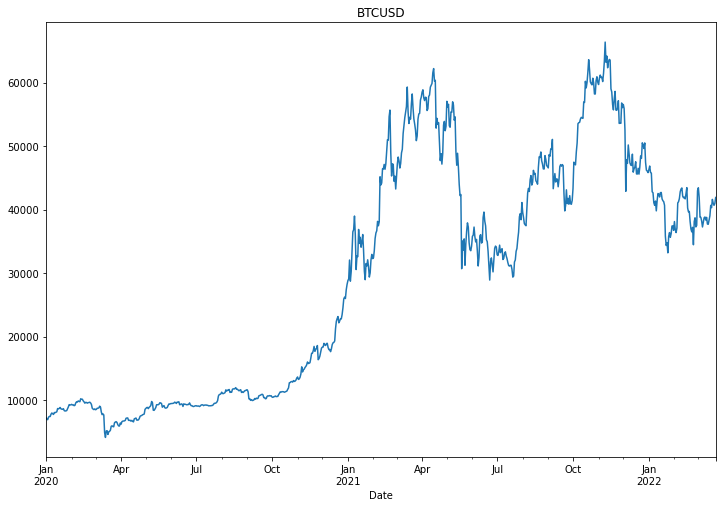

In [ ]:
df.plot(figsize = (12,8),title = 'BTCUSD')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare training documents, which are labeled.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0),
    (4, "b spark who", 1.0),
    (5, "g d a y", 0.0),
    (6, "spark fly", 1.0),
    (7, "was mapreduce", 0.0),
    (8, "e spark program", 1.0),
    (9, "a e c l", 0.0),
    (10, "spark compile", 1.0),
    (11, "hadoop software", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam,
# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(training)

# Prepare test documents, which are unlabeled.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "mapreduce spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    print(row)

Row(id=4, text='spark i j k', probability=DenseVector([0.2661, 0.7339]), prediction=1.0)
Row(id=5, text='l m n', probability=DenseVector([0.9209, 0.0791]), prediction=0.0)
Row(id=6, text='mapreduce spark', probability=DenseVector([0.4429, 0.5571]), prediction=1.0)
Row(id=7, text='apache hadoop', probability=DenseVector([0.8584, 0.1416]), prediction=0.0)
